# Tutorial: From physics to tuned GPU kernels

This tutorial is designed to show you the whole process starting from modeling a physical process to a Python implementation to creating optimized and auto-tuned GPU application using Kernel Tuner.

In this tutorial, we will use [diffusion](https://en.wikipedia.org/wiki/Diffusion) as an example application.

We start with modeling the physical process of diffusion, for which we create a simple numerical implementation in Python. Then we create a CUDA kernel that performs the same computation, but on the GPU. Once we have a CUDA kernel, we start using the Kernel Tuner for auto-tuning our GPU application. And finally, we'll introduce a few code optimizations to our CUDA kernel that will improve performance, but also add more parameters to tune on using the Kernel Tuner.

<div class="alert alert-info">

**Note:** If you are reading this tutorial on the Kernel Tuner's documentation pages, note that you can actually run this tutorial as a Jupyter Notebook. Just clone the Kernel Tuner's [GitHub repository](http://github.com/kerneltuner/kernel_tuner). Install using *pip install .[tutorial,cuda]* and you're ready to go! You can start the tutorial by typing "jupyter notebook" in the "kernel_tuner/tutorial" directory.

</div>

## Diffusion

Put simply, diffusion is the redistribution of something from a region of high concentration to a region of low concentration  without bulk motion. The concept of diffusion is widely used in many fields, including physics, chemistry, biology, and many more.

Suppose that we take a metal sheet, in which the temperature is exactly equal to one degree everywhere in the sheet.
Now if we were to heat a number of points on the sheet to a very high temperature, say a thousand degrees, in an instant by some method. We could see the heat diffuse from these hotspots to the cooler areas. We are assuming that the metal does not melt. In addition, we will ignore any heat loss from radiation or other causes in this example.

We can use the [diffusion equation](https://en.wikipedia.org/wiki/Diffusion_equation) to model how the heat diffuses through our metal sheet:

\begin{equation*}
\frac{\partial u}{\partial t}= D \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
\end{equation*}

Where $x$ and $y$ represent the spatial descretization of our 2D domain, $u$ is the quantity that is being diffused, $t$ is the descretization in time, and the constant $D$ determines how fast the diffusion takes place.

In this example, we will assume a very simple descretization of our problem. We assume that our 2D domain has $nx$ equi-distant grid points in the x-direction and $ny$ equi-distant grid points in the y-direction. Be sure to execute every cell as you read through this document, by selecting it and pressing **shift+enter**.

In [1]:
nx = 1024
ny = 1024

This results in a constant distance of $\delta x$ between all grid points in the $x$ dimension. Using central differences, we can numerically approximate the derivative for a given point $x_i$:

\begin{equation*}
\left. \frac{\partial^2 u}{\partial x^2} \right|_{x_{i}} \approx \frac{u_{x_{i+1}}-2u_{{x_i}}+u_{x_{i-1}}}{(\delta x)^2}
\end{equation*}

We do the same for the partial derivative in $y$:

\begin{equation*}
\left. \frac{\partial^2 u}{\partial y^2} \right|_{y_{i}} \approx \frac{u_{y_{i+1}}-2u_{y_{i}}+u_{y_{i-1}}}{(\delta y)^2}
\end{equation*}

If we combine the above equations, we can obtain a numerical estimation for the temperature field of our metal sheet in the next time step, using $\delta t$ as the time between time steps. But before we do, we also simplify the expression a little bit, because we'll assume that $\delta x$ and $\delta y$ are always equal to 1.

\begin{equation*}
u'_{x,y} = u_{x,y} + \delta t \times \left( \left( u_{x_{i+1},y}-2u_{{x_i},y}+u_{x_{i-1},y} \right) + \left( u_{x,y_{i+1}}-2u_{x,y_{i}}+u_{x,y_{i-1}} \right) \right)
\end{equation*}

In this formula $u'_{x,y}$ refers to the temperature field at the time $t + \delta t$. As a final step, we further simplify this equation to:

\begin{equation*}
u'_{x,y} = u_{x,y} + \delta t \times \left( u_{x,y_{i+1}}+u_{x_{i+1},y}-4u_{{x_i},y}+u_{x_{i-1},y}+u_{x,y_{i-1}} \right)
\end{equation*}

## Python implementation

We can create a Python function that implements the numerical approximation defined in the above equation. For simplicity we'll use the assumption of a free boundary condition.

In [2]:
def diffuse(field, dt=0.225):
    field[1:nx-1,1:ny-1] = field[1:nx-1,1:ny-1] + dt * (
        field[1:nx-1,2:ny]+field[2:nx,1:ny-1]-4*field[1:nx-1,1:ny-1]+
        field[0:nx-2,1:ny-1]+field[1:nx-1,0:ny-2] ) 
    return field

To give our Python function a test run, we will now do some imports and generate the input data for the initial conditions of our metal sheet with a few very hot points. We'll also make two plots, one after a thousand time steps, and a second plot after another two thousand time steps. Do note that the plots are using different ranges for the colors. Also, executing the following cell may take a little while.

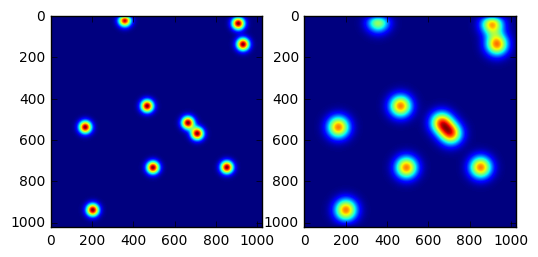

In [3]:
#do the imports we need
import numpy
from matplotlib import pyplot
%matplotlib inline

#setup initial conditions
def get_initial_conditions(nx, ny):
    field = numpy.ones((ny, nx)).astype(numpy.float32)
    field[numpy.random.randint(0,nx,size=10), numpy.random.randint(0,ny,size=10)] = 1e3
    return field
field = get_initial_conditions(nx, ny)

#run the diffuse function a 1000 times and another 2000 times and make plots
fig, (ax1, ax2) = pyplot.subplots(1,2)
for i in range(1000):
    field = diffuse(field)
ax1.imshow(field)
for i in range(2000):
    field = diffuse(field)
ax2.imshow(field)

Now let's take a quick look at the execution time of our diffuse function. Before we do, we also copy the current state of the metal sheet to be able to restart the computation from this state.

1000 steps of diffuse took 4164.018869400024 ms


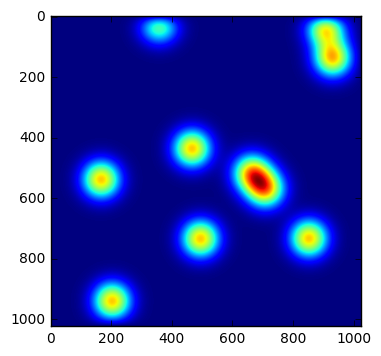

In [4]:
#save the current field for later use
field_copy = numpy.copy(field)

#run another 1000 steps of the diffuse function and measure the time
from time import time
start = time()
for i in range(1000):
    field = diffuse(field)
end = time()
print("1000 steps of diffuse took", (end-start)*1000.0, "ms")
pyplot.imshow(field)

## Computing on the GPU

The next step in this tutorial is to implement a GPU kernel that will allow us to run our problem on the GPU. We store the kernel code in a Python string, because we can directly compile and run the kernel from Python. In this tutorial, we'll use the CUDA programming model to implement our kernels.

>    If you prefer OpenCL over CUDA, don't worry. Everything in this tutorial 
>    applies as much to OpenCL as it does to CUDA. But we will use CUDA for our 
>    examples, and CUDA terminology in the text. 

In [5]:
def get_kernel_string(nx, ny):
    return """
    #define nx %d
    #define ny %d
    #define dt 0.225f
    __global__ void diffuse_kernel(float *u_new, float *u) {
        int x = blockIdx.x * block_size_x + threadIdx.x;
        int y = blockIdx.y * block_size_y + threadIdx.y;

        if (x>0 && x<nx-1 && y>0 && y<ny-1) {
            u_new[y*nx+x] = u[y*nx+x] + dt * ( 
                u[(y+1)*nx+x]+u[y*nx+x+1]-4.0f*u[y*nx+x]+u[y*nx+x-1]+u[(y-1)*nx+x]);
        }
    }
    """ % (nx, ny)
kernel_string = get_kernel_string(nx, ny)

The above CUDA kernel parallelizes the work such that every grid point will be processed by a different CUDA thread. Therefore, the kernel is executed by a 2D grid of threads, which are grouped together into 2D thread blocks. The specific thread block dimensions we choose are not important for the result of the computation in this kernel. But as we will see will later, they will have an impact on performance.

In this kernel we are using two, currently undefined, compile-time constants for `block_size_x` and `block_size_y`, because we will auto tune these parameters later. It is often needed for performance to fix the thread block dimensions at compile time, because the compiler can unroll loops that iterate using the block size, or because you need to allocate shared memory using the thread block dimensions.

The next bit of Python code initializes PyCuda, and makes preparations so that we can call the CUDA kernel to do the computation on the GPU as we did earlier in Python.

In [6]:
import pycuda.driver as drv
from pycuda.compiler import SourceModule

#initialize PyCuda and get compute capability needed for compilation
drv.init()
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])

#allocate GPU memory
u_old = drv.mem_alloc(field_copy.nbytes)
u_new = drv.mem_alloc(field_copy.nbytes)

#setup thread block dimensions and compile the kernel
threads = (16,16,1)
grid = (int(nx/16), int(ny/16), 1)
block_size_string = "#define block_size_x 16\n#define block_size_y 16\n"
diffuse_kernel = SourceModule(block_size_string+kernel_string,
                              arch='sm_'+cc).get_function("diffuse_kernel")

#create events for measuring performance
start = drv.Event()
end = drv.Event()

The above code is a bit of boilerplate we need to compile a kernel using PyCuda. We've also, for the moment, fixed the thread block dimensions at 16 by 16. These dimensions serve as our initial guess for what a good performing pair of thread block dimensions could look like.

Now that we've setup everything, let's see how long the computation would take using the GPU.

1000 steps of diffuse took 53.423038482666016 ms.


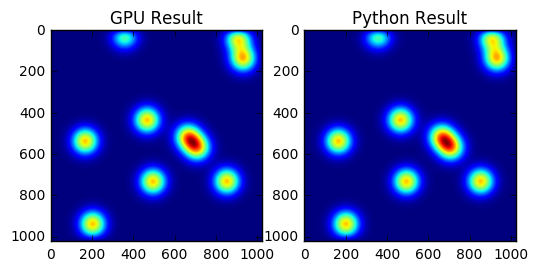

In [7]:
#move the data to the GPU
drv.memcpy_htod(u_old, field_copy)
drv.memcpy_htod(u_new, field_copy)

#call the GPU kernel a 1000 times and measure performance
context.synchronize()
start.record()
for i in range(500):
    diffuse_kernel(u_new, u_old, block=threads, grid=grid)
    diffuse_kernel(u_old, u_new, block=threads, grid=grid)
end.record()
context.synchronize()
print("1000 steps of diffuse took", end.time_since(start), "ms.")

#copy the result from the GPU to Python for plotting
gpu_result = numpy.zeros_like(field_copy)
drv.memcpy_dtoh(gpu_result, u_new)
fig, (ax1, ax2) = pyplot.subplots(1,2)
ax1.imshow(gpu_result)
ax1.set_title("GPU Result")
ax2.imshow(field)
ax2.set_title("Python Result")

That should already be a lot faster than our previous Python implementation, but we can do much better if we optimize our GPU kernel. And that is exactly what the rest of this tutorial is about!

In [8]:
#cleanup the PyCuda context
context.pop()

Also, if you think the Python boilerplate code to call a GPU kernel was a bit messy, we've got good news for you! From now on, we'll only use the Kernel Tuner to compile and benchmark GPU kernels, which we can do with much cleaner Python code.

## Auto-Tuning with the Kernel Tuner

Remember that previously we've set the thread block dimensions to 16 by 16. But how do we actually know if that is the best performing setting? That is where auto-tuning comes into play. Basically, it is very difficult to provide an answer through performance modeling and as such, we'd rather use the Kernel Tuner to compile and benchmark all possible kernel configurations.

But before we continue, we'll increase the problem size, because the GPU is very likely underutilized.

In [9]:
nx = 4096
ny = 4096
field = get_initial_conditions(nx, ny)
kernel_string = get_kernel_string(nx, ny)

The above code block has generated new initial conditions and a new string that contains our CUDA kernel using our new domain size.

To call the Kernel Tuner, we have to specify the tunable parameters, in our case `block_size_x` and `block_size_y`. For this purpose, we'll create an ordered dictionary to store the tunable parameters. The keys will be the name of the tunable parameter, and the corresponding value is the list of possible values for the parameter. For the purpose of this tutorial, we'll use a small number of commonly used values for the thread block dimensions, but feel free to try more!

In [10]:
from collections import OrderedDict
tune_params = OrderedDict()
tune_params["block_size_x"] = [16, 32, 48, 64, 128]
tune_params["block_size_y"] = [2, 4, 8, 16, 32]

We also have to tell the Kernel Tuner about the argument list of our CUDA kernel. Because the Kernel Tuner will be calling the CUDA kernel and measure its execution time. For this purpose we create a list in Python, that corresponds with the argument list of the `diffuse_kernel` CUDA function. This list will only be used as input to the kernel during tuning. The objects in the list should be Numpy arrays or scalars.

Because you can specify the arguments as Numpy arrays, the Kernel Tuner will take care of allocating GPU memory and copying the data to the GPU.

In [11]:
args = [field, field]

We're almost ready to call the Kernel Tuner, we just need to set how large the problem is we are currently working on by setting a `problem_size`. The Kernel Tuner knows about thread block dimensions, which it expects to be called `block_size_x`, `block_size_y`, and/or `block_size_z`. From these and the `problem_size`, the Kernel Tuner will compute the appropiate grid dimensions on the fly.

In [12]:
problem_size = (nx, ny)

And that's everything the Kernel Tuner needs to know to be able to start tuning our kernel. Let's give it a try by executing the next code block!

In [13]:
from kernel_tuner import tune_kernel
result = tune_kernel("diffuse_kernel", kernel_string, problem_size, args, tune_params)

Using: GeForce GTX TITAN X
diffuse_kernel
block_size_x=16, block_size_y=2, time=1.22305920124, 
block_size_x=16, block_size_y=4, time=0.779033613205, 
block_size_x=16, block_size_y=8, time=0.824838399887, 
block_size_x=16, block_size_y=16, time=0.900499212742, 
block_size_x=16, block_size_y=32, time=0.999763202667, 
block_size_x=32, block_size_y=2, time=0.727967989445, 
block_size_x=32, block_size_y=4, time=0.752479994297, 
block_size_x=32, block_size_y=8, time=0.797900807858, 
block_size_x=32, block_size_y=16, time=0.876627194881, 
block_size_x=32, block_size_y=32, time=0.93347837925, 
block_size_x=48, block_size_y=2, time=0.766662418842, 
block_size_x=48, block_size_y=4, time=0.803033602238, 
block_size_x=48, block_size_y=8, time=0.853574407101, 
block_size_x=48, block_size_y=16, time=0.971545600891, 
block_size_x=64, block_size_y=2, time=0.763775992393, 
block_size_x=64, block_size_y=4, time=0.791257584095, 
block_size_x=64, block_size_y=8, time=0.848044800758, 
block_size_x=64, blo

Note that the Kernel Tuner prints a lot of useful information. To ensure you'll be able to tell what was measured in this run the Kernel Tuner always prints the GPU or OpenCL Device name that is being used, as well as the name of the kernel.
After that every line contains the combination of parameters and the time that was measured during benchmarking. The time that is being printed is in milliseconds and is obtained by averaging the execution time of 7 runs of the kernel. Finally, as a matter of convenience, the Kernel Tuner also prints the best performing combination of tunable parameters. However, later on in this tutorial we'll explain how to analyze and store the tuning results using Python.

Looking at the results printed above, the difference in performance between the different kernel configurations may seem very little. However, on our hardware, the performance of this kernel already varies in the order of 10%. Which of course can build up to large differences in the execution time if the kernel is to be executed thousands of times. We can also see that the performance of the best configuration in this set is 5% better than our initially guessed thread block dimensions of 16 by 16.

In addtion, you may notice that not all possible combinations of values for `block_size_x` and `block_size_y` are among the results. For example, 128x32 is not among the results. This is because some configuration require more threads per thread block than allowed on our GPU. The Kernel Tuner checks the limitations of your GPU at runtime and automatically skips over configurations that use too many threads per block. It will also do this for kernels that cannot be compiled because they use too much shared memory. And likewise for kernels that use too many registers to be launched at runtime. If you'd like to know about which configurations were skipped automatically you can pass the optional parameter `verbose=True` to `tune_kernel`.

However, knowing the best performing combination of tunable parameters becomes even more important when we start to further optimize our CUDA kernel. In the next section, we'll add a simple code optimization and show how this affects performance.

## Using Shared Memory

Shared memory, is a special type of the memory available in CUDA. Shared memory can be used by threads within the same thread block to exchange and share values. It is in fact, one of the very few ways for threads to communicate on the GPU.

The idea is that we'll try improve the performance of our kernel by using shared memory as a software controlled cache. There are already caches on the GPU, but most GPUs only cache accesses to global memory in L2. Shared memory is closer to the multiprocessors where the thread blocks are executed, comparable to an L1 cache.

However, because there are also hardware caches, the performance improvement from this step is expected to not be that great. The more fine-grained control that we get by using a software managed cache, rather than a hardware implemented cache, comes at the cost of some instruction overhead. In fact, performance is quite likely to degrade a little. However, this intermediate step is necessary for the next optimization step we have in mind.

In [14]:
kernel_string = """ 
#define nx %d
#define ny %d
#define dt 0.225f
__global__ void diffuse_kernel(float *u_new, float *u) {

    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int bx = blockIdx.x * block_size_x;
    int by = blockIdx.y * block_size_y;

    __shared__ float sh_u[block_size_y+2][block_size_x+2];

    #pragma unroll
    for (int i = ty; i<block_size_y+2; i+=block_size_y) {
        #pragma unroll
        for (int j = tx; j<block_size_x+2; j+=block_size_x) {
            int y = by+i-1;
            int x = bx+j-1;
            if (x>=0 && x<nx && y>=0 && y<ny) {
                sh_u[i][j] = u[y*nx+x];
            }
        }
    }
    __syncthreads();
    
    int x = bx+tx;
    int y = by+ty;
    if (x>0 && x<nx-1 && y>0 && y<ny-1) {
        int i = ty+1;
        int j = tx+1;
        u_new[y*nx+x] = sh_u[i][j] + dt * ( 
            sh_u[i+1][j] + sh_u[i][j+1] -4.0f * sh_u[i][j] +
            sh_u[i][j-1] + sh_u[i-1][j] );
    }    

}
""" % (nx, ny)
result = tune_kernel("diffuse_kernel", kernel_string, problem_size, args, tune_params)

Using: GeForce GTX TITAN X
diffuse_kernel
block_size_x=16, block_size_y=2, time=1.75041918755, 
block_size_x=16, block_size_y=4, time=1.18713598251, 
block_size_x=16, block_size_y=8, time=1.09015038013, 
block_size_x=16, block_size_y=16, time=1.06844799519, 
block_size_x=16, block_size_y=32, time=1.09730558395, 
block_size_x=32, block_size_y=2, time=1.14420480728, 
block_size_x=32, block_size_y=4, time=1.05957758427, 
block_size_x=32, block_size_y=8, time=1.07508480549, 
block_size_x=32, block_size_y=16, time=1.0731967926, 
block_size_x=32, block_size_y=32, time=1.14729599953, 
block_size_x=48, block_size_y=2, time=1.08389122486, 
block_size_x=48, block_size_y=4, time=1.10700161457, 
block_size_x=48, block_size_y=8, time=1.10125439167, 
block_size_x=48, block_size_y=16, time=1.31661438942, 
block_size_x=64, block_size_y=2, time=1.0629119873, 
block_size_x=64, block_size_y=4, time=1.04807043076, 
block_size_x=64, block_size_y=8, time=1.054880023, 
block_size_x=64, block_size_y=16, time=

## Tiling GPU Code

One very useful code optimization is called tiling, sometimes also called thread-block-merge. You can look at it in this way, currently we have many thread blocks that together work on the entire domain. If we were to use only half of the number of thread blocks, every thread block would need to double the amount of work it performs to cover the entire domain. However, the threads may be able to reuse part of the data and computation that is required to process a single output element for every element beyond the first.

This is a code optimization because effectively we are reducing the total number of instructions executed by all threads in all thread blocks. So in a way, were are condensing the total instruction stream while keeping the all the really necessary compute instructions. More importantly, we are increasing data reuse, where previously these values would have been reused from the cache or in the worst-case from GPU memory.

We can apply tiling in both the x and y-dimensions. This also introduces two new tunable parameters, namely the tiling factor in x and y, which we will call `tile_size_x` and `tile_size_y`. 
This is what the new kernel looks like:

In [15]:
kernel_string = """ 
#define nx %d
#define ny %d
#define dt 0.225f
__global__ void diffuse_kernel(float *u_new, float *u) {

    int tx = threadIdx.x;
    int ty = threadIdx.y;
    int bx = blockIdx.x * block_size_x * tile_size_x;
    int by = blockIdx.y * block_size_y * tile_size_y;

    __shared__ float sh_u[block_size_y*tile_size_y+2][block_size_x*tile_size_x+2];

    #pragma unroll
    for (int i = ty; i<block_size_y*tile_size_y+2; i+=block_size_y) {
        #pragma unroll
        for (int j = tx; j<block_size_x*tile_size_x+2; j+=block_size_x) {
            int y = by+i-1;
            int x = bx+j-1;
            if (x>=0 && x<nx && y>=0 && y<ny) {
                sh_u[i][j] = u[y*nx+x];
            }
        }
    }
    __syncthreads();
    
    #pragma unroll
    for (int tj=0; tj<tile_size_y; tj++) {
        int i = ty+tj*block_size_y+1;
        int y = by + ty + tj*block_size_y;
        #pragma unroll
        for (int ti=0; ti<tile_size_x; ti++) {
            int j = tx+ti*block_size_x+1;
            int x = bx + tx + ti*block_size_x;
            if (x>0 && x<nx-1 && y>0 && y<ny-1) {
                u_new[y*nx+x] = sh_u[i][j] + dt * ( 
                    sh_u[i+1][j] + sh_u[i][j+1] -4.0f * sh_u[i][j] +
                    sh_u[i][j-1] + sh_u[i-1][j] );
            }
        }
    
    }

}
""" % (nx, ny)

We can tune our tiled kernel by adding the two new tunable parameters to our dictionary `tune_params`.

We also need to somehow tell the Kernel Tuner to use fewer thread blocks to launch kernels with `tile_size_x` or `tile_size_y` larger than one. For this purpose the Kernel Tuner's `tune_kernel` function supports two optional arguments, called grid_div_x and grid_div_y. These are the grid divisor lists, which are lists of strings containing all the tunable parameters that divide a certain grid dimension. So far, we have been using the default settings for these, in which case the Kernel Tuner only uses the block_size_x and block_size_y tunable parameters to divide the problem_size.

Note that the Kernel Tuner will replace the values of the tunable parameters inside the strings and use the product of the parameters in the grid divisor list to compute the grid dimension rounded up. You can even use arithmetic operations, inside these strings as they will be evaluated. As such, we could have used ``["block_size_x*tile_size_x"]`` to get the same result.

We are now ready to call the Kernel Tuner again and tune our tiled kernel. Let's execute the following code block, note that it may take a while as the number of kernel configurations that the Kernel Tuner will try has just been increased with a factor of 9!

In [16]:
tune_params["tile_size_x"] = [1,2,4]            #add tile_size_x to the tune_params
tune_params["tile_size_y"] = [1,2,4]            #add tile_size_y to the tune_params
grid_div_x = ["block_size_x", "tile_size_x"]    #tile_size_x impacts grid dimensions
grid_div_y = ["block_size_y", "tile_size_y"]    #tile_size_y impacts grid dimensions
result = tune_kernel("diffuse_kernel", kernel_string, problem_size, args,
                     tune_params, grid_div_x=grid_div_x, grid_div_y=grid_div_y)

Using: GeForce GTX TITAN X
diffuse_kernel
block_size_x=16, block_size_y=2, tile_size_x=1, tile_size_y=1, time=1.759308815, 
block_size_x=16, block_size_y=2, tile_size_x=1, tile_size_y=2, time=1.29789438248, 
block_size_x=16, block_size_y=2, tile_size_x=1, tile_size_y=4, time=1.06983039379, 
block_size_x=16, block_size_y=2, tile_size_x=2, tile_size_y=1, time=1.2634239912, 
block_size_x=16, block_size_y=2, tile_size_x=2, tile_size_y=2, time=0.997139203548, 
block_size_x=16, block_size_y=2, tile_size_x=2, tile_size_y=4, time=0.843692803383, 
block_size_x=16, block_size_y=2, tile_size_x=4, tile_size_y=1, time=1.05549435616, 
block_size_x=16, block_size_y=2, tile_size_x=4, tile_size_y=2, time=0.862348806858, 
block_size_x=16, block_size_y=2, tile_size_x=4, tile_size_y=4, time=0.750636804104, 
block_size_x=16, block_size_y=4, tile_size_x=1, tile_size_y=1, time=1.19084160328, 
block_size_x=16, block_size_y=4, tile_size_x=1, tile_size_y=2, time=0.876377594471, 
block_size_x=16, block_size_y=4,

We can see that the number of kernel configurations tried by the Kernel Tuner is growing rather quickly. Also, the best performing configuration quite a bit faster than the best kernel before we started optimizing. On our GTX Titan X, the execution time went from 0.72 ms to 0.53 ms, a performance improvement of 26%!

Note that the thread block dimensions for this kernel configuration are also different. Without optimizations the best performing kernel used a thread block of 32x2, after we've added tiling the best performing kernel uses thread blocks of size 64x4, which is four times as many threads! Also the amount of work increased with tiling factors 2 in the x-direction and 4 in the y-direction, increasing the amount of work per thread block by a factor of 8. The difference in the area processed per thread block between the naive and the tiled kernel is a factor 32.

However, there are actually several kernel configurations that come close. The following Python code prints all instances with an execution time within 5% of the best performing configuration.

In [17]:
best_time = min(result[0], key=lambda x:x['time'])['time']
for i in result[0]:
    if i["time"] < best_time*1.05:
        print("".join([k + "=" + str(v) + ", " for k,v in i.items()]))

block_size_x=16, block_size_y=8, tile_size_x=2, tile_size_y=4, time=0.554745602608, 
block_size_x=32, block_size_y=2, tile_size_x=2, tile_size_y=4, time=0.563417613506, 
block_size_x=32, block_size_y=4, tile_size_x=2, tile_size_y=4, time=0.542387211323, 
block_size_x=32, block_size_y=8, tile_size_x=2, tile_size_y=4, time=0.539891195297, 
block_size_x=32, block_size_y=16, tile_size_x=2, tile_size_y=4, time=0.550105595589, 
block_size_x=48, block_size_y=2, tile_size_x=2, tile_size_y=4, time=0.560505592823, 
block_size_x=48, block_size_y=4, tile_size_x=2, tile_size_y=4, time=0.562521612644, 
block_size_x=64, block_size_y=2, tile_size_x=2, tile_size_y=4, time=0.544691193104, 
block_size_x=64, block_size_y=4, tile_size_x=2, tile_size_y=4, time=0.540352010727, 
block_size_x=64, block_size_y=8, tile_size_x=2, tile_size_y=4, time=0.538227200508, 
block_size_x=128, block_size_y=2, tile_size_x=2, tile_size_y=4, time=0.542937588692, 
block_size_x=128, block_size_y=4, tile_size_x=2, tile_size_y=4,

## Storing the results

While it's nice that the Kernel Tuner prints the tuning results to stdout, it's not that great if we'd have to parse what is printed to get the results. That is why the `tune_kernel()` returns a data structure that holds all the results. We've actually already used this data in the above bit of Python code.

`tune_kernel` returns a list of dictionaries, where each benchmarked kernel is represented by a dictionary containing the tunable parameters for that particular kernel configuration and one more entry called 'time'. The list of dictionaries format is very flexible and can easily be converted other formats that are easy to parse formats, like json or csv, for further analysis.

You can execute the following code block to store the tuning results to both a json and a csv file (if you have Pandas installed).

In [18]:
#store output as json
import json
with open("tutorial.json", 'w') as fp:
    json.dump(result[0], fp)

#store output as csv
from pandas import DataFrame
df = DataFrame(result[0])
df.to_csv("tutorial.csv")